In [1]:
%matplotlib inline

from cosima_cookbook import build_index, get_nc_variable
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import joblib
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import IPython.display

netcdf_index loaded.


/home/156/al1353/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
memory = joblib.Memory(cachedir='.')

In [3]:
expts = ['gfdl_nyf_1080_cp','gfdl_nyf_1080_SH','gfdl_nyf_1080_PI','gfdl_nyf_1080_UP']

# Load data

In [4]:
u = get_nc_variable(expts[0],'ocean__\d+_\d+.nc','u',n=10, time_units='days since 1900-01-01')

dzt = get_nc_variable(expts[0],'ocean__\d+_\d+.nc','dzt',n=10, time_units='days since 1900-01-01')

yt_ocean = get_nc_variable(expts[0],'ocean__\d+_\d+.nc','yt_ocean',n=10, time_units='days since 1900-01-01')

rho = get_nc_variable(expts[0],'ocean__\d+_\d+.nc','pot_rho_2',n=10, time_units='days since 1900-01-01')

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=10), HTML(value='')))

/home/156/al1353/cosima-cookbook/cosima_cookbook/netcdf_index.py:368: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  decoded_time = xr.conventions.decode_cf_datetime(dataarray.time, time_units)


HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=10), HTML(value='')))

# 1.Change the coordinates of the u_t 

In [5]:
u_t = dzt.copy()*0.0
u_t.name = 'u_t'
u_t.load()
u_t[0,:,2:,2:] = 0.25*(u[0,:,1:,1:] + u[0,:,:-1,:-1] + u[0,:,1:,:-1] + u[0,:,:-1,1:])

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


# 2. Calculate the tx_trans

In [6]:
a=u_t[0,0,:,:]*dzt[0,0,:,:]

b=a[:,0]*yt_ocean

c=dzt.copy()*0.0

c.load()

c[:,:,0,0]=u_t[:,:,0,0]

c[0,0,:,0]=b

c[0,0,0,:]=a[0,:]

tx_trans = c

# 3. Transport

In [8]:
@memory.cache
def calc_transport(expt):
    
    tx_trans_inz=tx_trans.sel(yt_ocean=slice(None, -10))\
                     .sel(xu_ocean=slice(0, 60))\
                     .sum('st_ocean')  

    streamfunction = tx_trans_inz.cumsum('yt_ocean') # integrate in y direction

    streamfunction0 = streamfunction.sel(xu_ocean=20, yt_ocean=-10, method='nearest') # select somewhere
    # on the continent to be reference point 

    transport = - (streamfunction - streamfunction0) # To make the transport on the continent to be 0
    
    transport = transport.compute()
    
    return transport

# 4. AL

In [9]:
@memory.cache
def mask(expt):
    
    al_rho = rho\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xt_ocean=20, method='nearest')\
                .isel(time=slice(None,100))\
                .compute()
    al_mask = (al_rho >= 1026.5)
    
    return al_mask

In [10]:
@memory.cache
def calc_altransport(expt):
    
    al_tx_trans = tx_trans\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xt_ocean=20, method='nearest')\
                .isel(time=slice(None,100))\
                .compute()
    
    return al_tx_trans

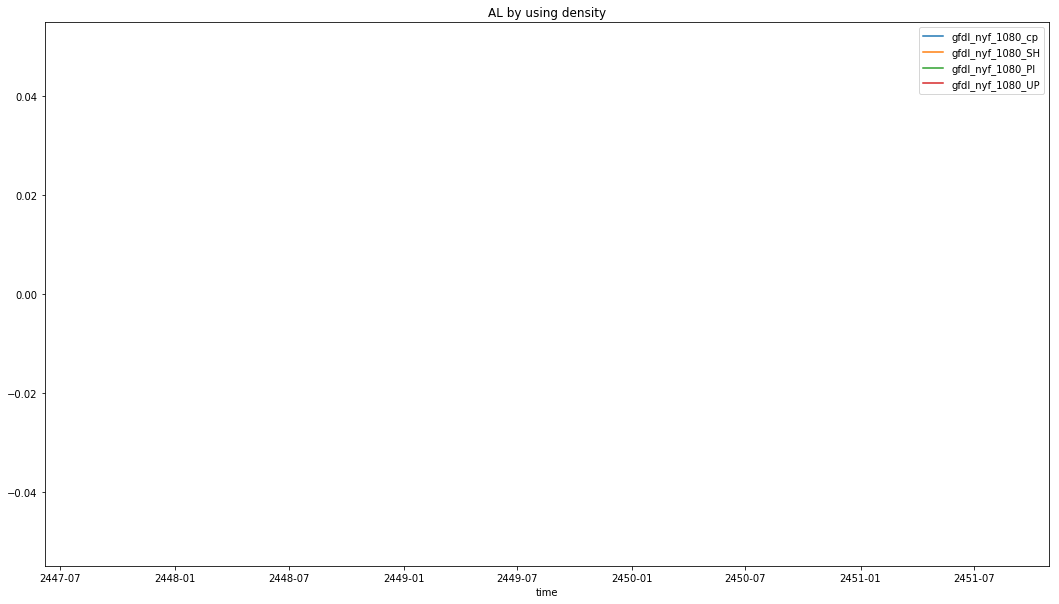

In [11]:
plt.figure(figsize=(18,10))
for expt in expts:
    al_mask = mask(expt)
    al_tx_trans = calc_altransport(expt)
    al_trans = -(al_tx_trans * al_mask).sum('yt_ocean').sum('st_ocean')
    al_trans.plot.line(label=expt)
plt.title('AL by using density')
plt.legend()